# AutoML - praca domowa 1
## Preprocessing danych zbioru Diabetes 130-US hospitals for years 1999-2008 Data Set
##### Michał Tomczyk

In [132]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from matplotlib import pyplot as plt

df = pd.read_csv('diabetic_data.csv')
df2 = pd.read_csv('IDs_mapping.csv')

Na początek sprawdźmy jakie kolumny mamy w zbiorze danych oraz jak wyglądają pierwsze jego wiersze.

In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [134]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


### Wybór zmiennej objaśnianej i zmiennych objaśniających

Zmienną objaśnianą jest zmienna readmitted, gdyż chcemy przewidzieć szanse na ponowny wpis do szpitala danej osoby. Zmiennymi objaśniającymi mogą być wszystkie zmienne oprócz readmitted, ancounter_id i patient_nbr - pierwsza z nich to zmienna objaśniająca, pozostałe dwie są indeksami wizyt i pacjentów, nie wnoszą więc nic nowego. Możemy je więc już na starcie usunąć.

In [135]:
df = df.drop(['encounter_id', 'patient_nbr'], axis = 1)

Sprawdźmy ile każda ze zmiennych posiada unikatowych atrybutów

In [136]:
df.apply(lambda x: len(x.unique()))

race                          6
gender                        3
age                          10
weight                       10
admission_type_id             8
discharge_disposition_id     26
admission_source_id          17
time_in_hospital             14
payer_code                   18
medical_specialty            73
num_lab_procedures          118
num_procedures                7
num_medications              75
number_outpatient            39
number_emergency             33
number_inpatient             21
diag_1                      717
diag_2                      749
diag_3                      790
number_diagnoses             16
max_glu_serum                 4
A1Cresult                     4
metformin                     4
repaglinide                   4
nateglinide                   4
chlorpropamide                4
glimepiride                   4
acetohexamide                 2
glipizide                     4
glyburide                     4
tolbutamide                   2
pioglita

Możemy uznać, że zmienne: num_lab_procedures, num_medications, number_outpatient, number_emergency, number_inpatient są numeryczne. Pozostałe albo są zmiennymi tekstowymi, albo są liczbowe i posiadają małą ilość unikalnych wartości, przez co będziemy je traktować jako kategoryczne.

### Brakujące dane

In [137]:
df_drop = df[df.isna().any(axis = 1)]
df_drop

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted


Widzimy, że nie mamy w zbiorze typowych braków danych, za to możemy zauważyć, że braki danych są zapisywane jako "?". Sprawdźmy ile dla każdej zmiennej procentowo mamy braków danych:

In [138]:
df.apply(lambda x: 100*sum(~x.isin(["?", -1000]))/len(df))

race                         97.766445
gender                      100.000000
age                         100.000000
weight                        3.141521
admission_type_id           100.000000
discharge_disposition_id    100.000000
admission_source_id         100.000000
time_in_hospital            100.000000
payer_code                   60.442584
medical_specialty            50.917792
num_lab_procedures          100.000000
num_procedures              100.000000
num_medications             100.000000
number_outpatient           100.000000
number_emergency            100.000000
number_inpatient            100.000000
diag_1                       99.979364
diag_2                       99.648213
diag_3                       98.601694
number_diagnoses            100.000000
max_glu_serum               100.000000
A1Cresult                   100.000000
metformin                   100.000000
repaglinide                 100.000000
nateglinide                 100.000000
chlorpropamide           

Tylko 3% recordów nie posiada braku w zmiennej weight, więc możemy ją usunąć, gdyż nie wniesie i tak nic do modelu. Możemy także usunąć zmienne payer_code i medical_specialty, gdyż niemal połowa recordów ma w nich braki danych. W przypadku zmiennych race, diag_1, diag_2 i diag_3 ilość recordów zawierających brak danych jest szczątkowa, możemy więc takie recordy usunąć.

In [139]:
df = df.drop(['weight','payer_code', 'medical_specialty'], axis = 1)
df = df[(df['race'] != "?") & (df['diag_1'] != "?") & (df['diag_2'] != "?") & (df['diag_3'] != "?")]

### Transformacja zmiennych

Musimy zająć się zmienną age, która podawana jest w przedziałach dziesięcioletnich. W łatwy sposób możemy otrzymać zmienną numeryczną, przypisując każdemu recordowi wartość będącą środkiem danego przedziału:

In [140]:
dict = {
    '[0-10)' : 5,
    '[10-20)' : 15,
    '[20-30)' : 25,
    '[30-40)' : 35,
    '[40-50)' : 45,
    '[50-60)' : 55,
    '[60-70)' : 65,
    '[70-80)' : 75,
    '[80-90)' : 85,
    '[90-100)' : 95
}
df['age'] = df['age'].map(dict)

W zmiennych diag_1, diag_2 i diag_3 mamy dużo kategorii rzadko występujących. Dobrze by było zamiast nich utworzyć kategorię other

In [141]:
def change_to_other(variable):
    list_of_rare_vals = variable.value_counts() < 200
    return variable.apply(lambda x: 'other' if list_of_rare_vals[x] else x)
df['diag_1'] = change_to_other(df['diag_1'])
df['diag_2'] = change_to_other(df['diag_2'])
df['diag_3'] = change_to_other(df['diag_3'])


### Eksploracyjna analiza danych

##### jednowymiarowa 

histogramy zmiennych:

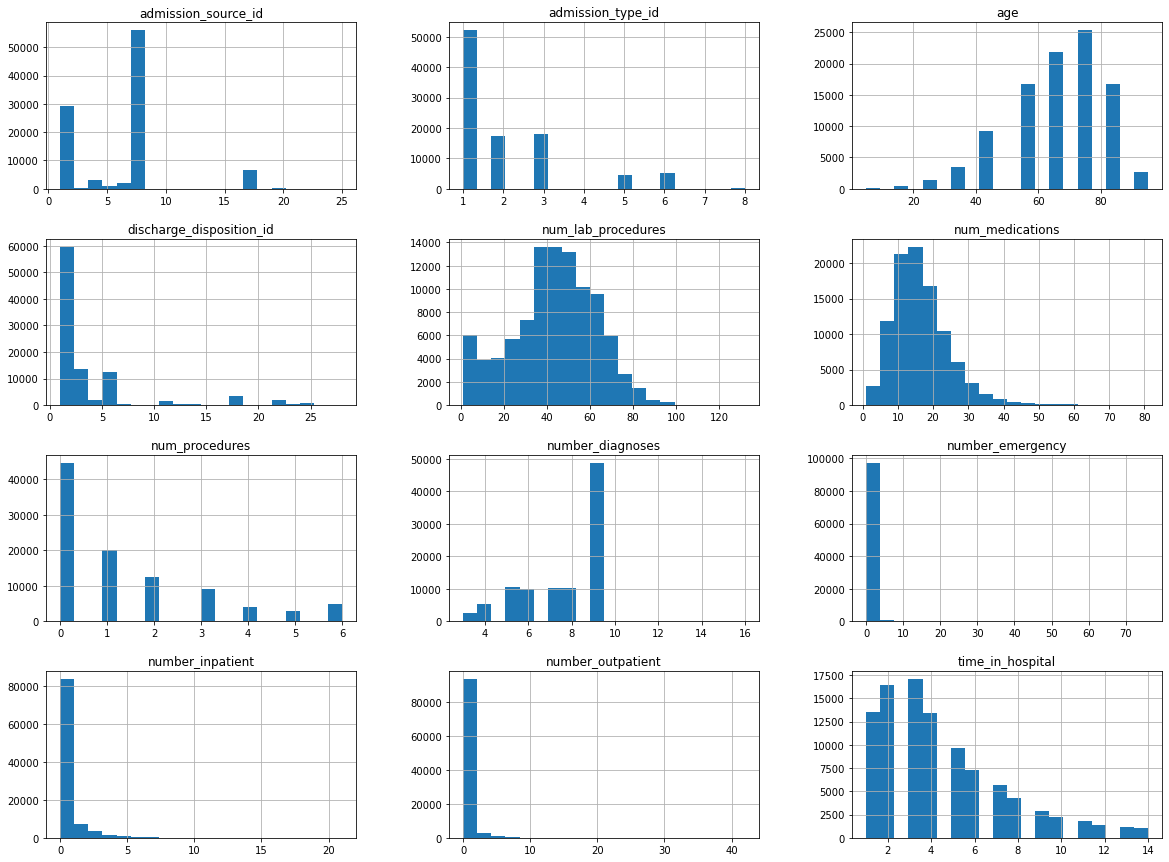

In [142]:
numerical_df = df[df.columns[df.dtypes == 'int64']]
numerical_df.hist(column = numerical_df.columns, figsize = [20,15], bins = 20)
plt.show()

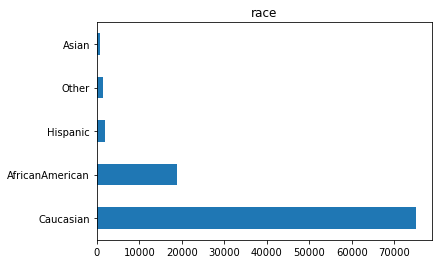

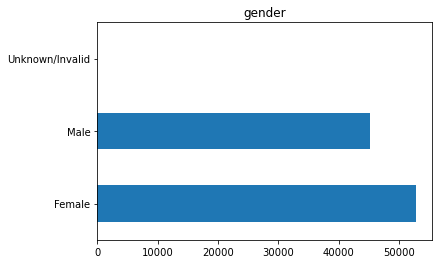

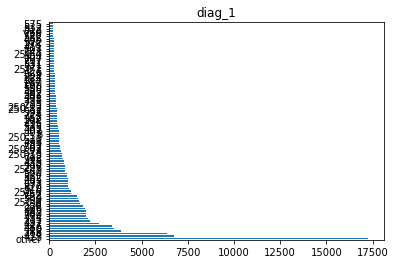

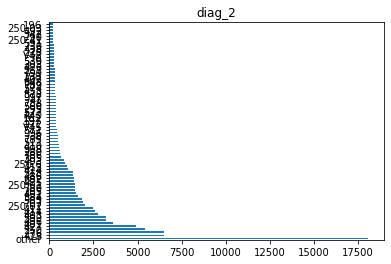

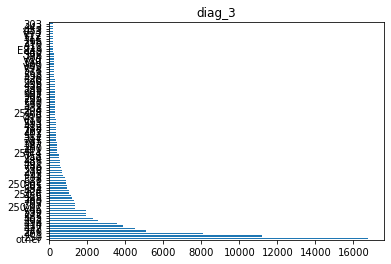

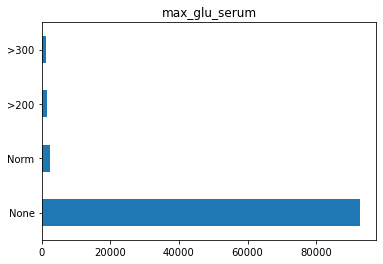

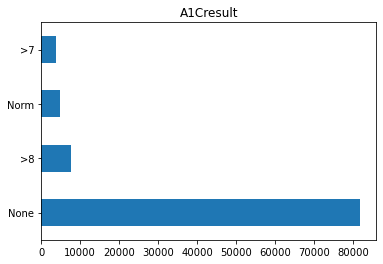

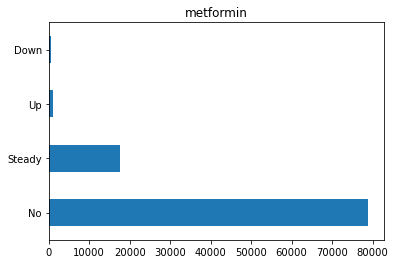

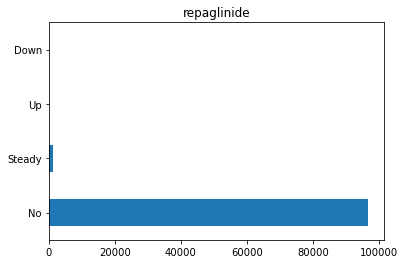

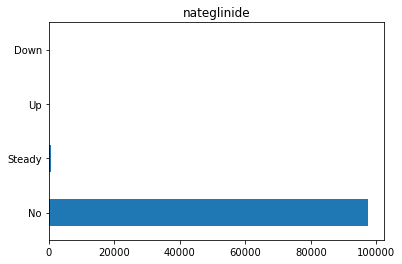

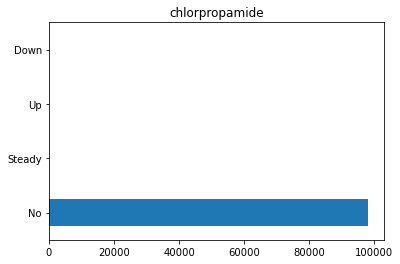

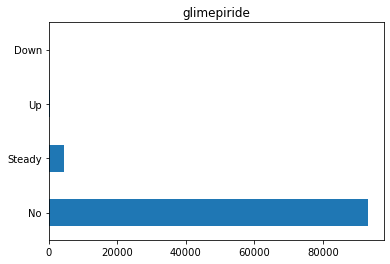

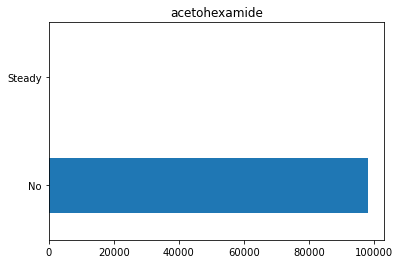

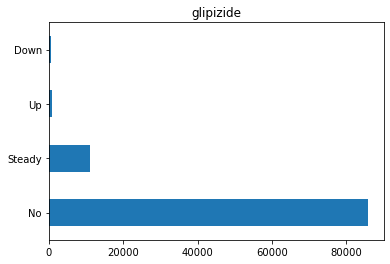

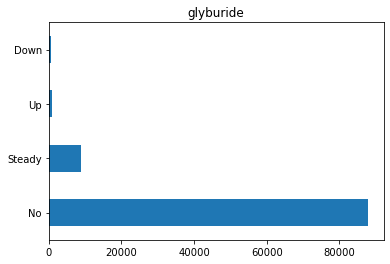

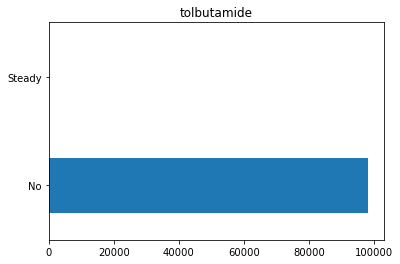

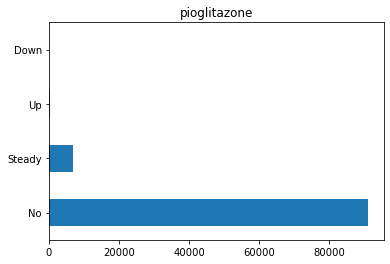

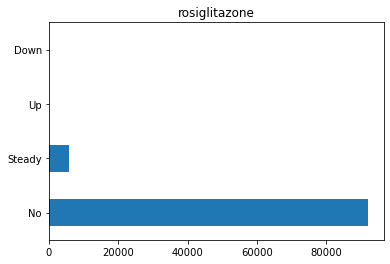

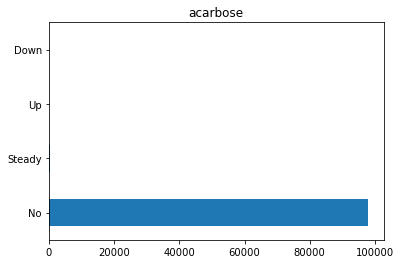

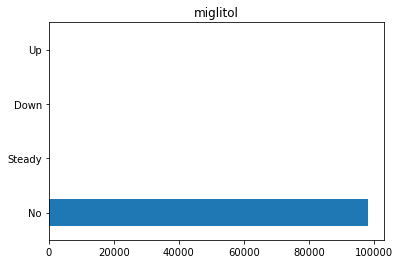

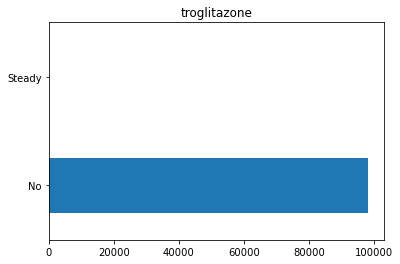

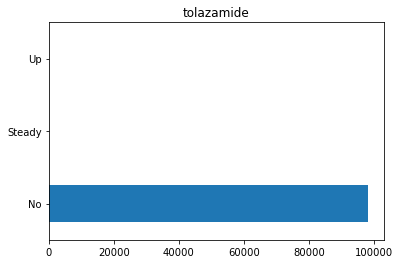

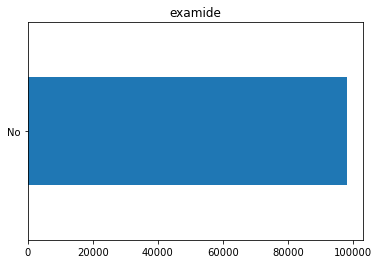

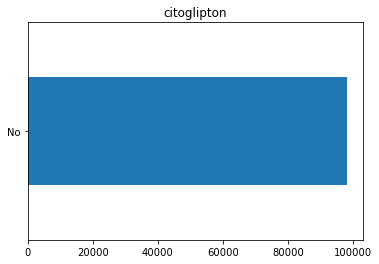

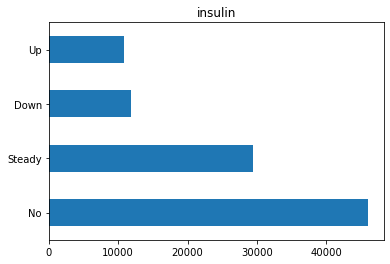

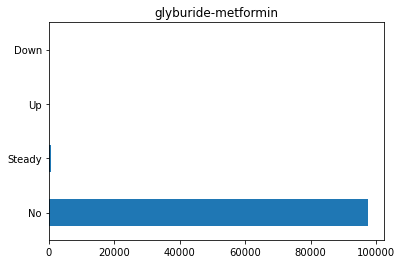

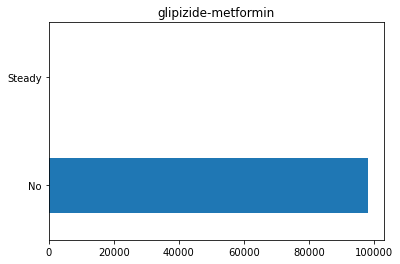

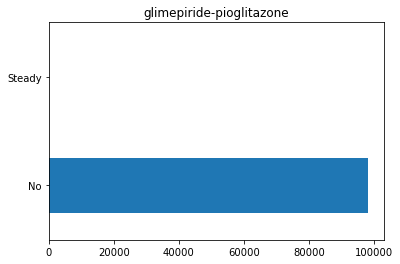

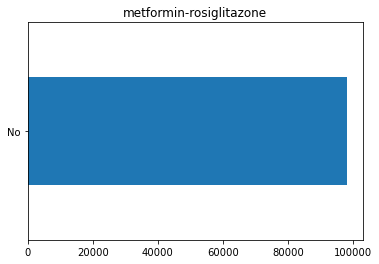

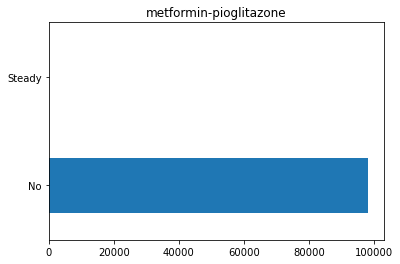

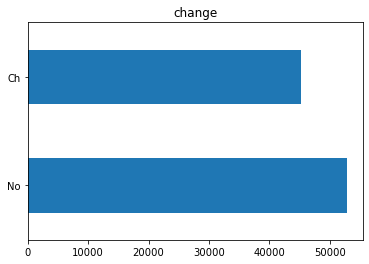

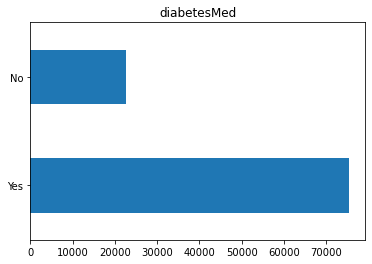

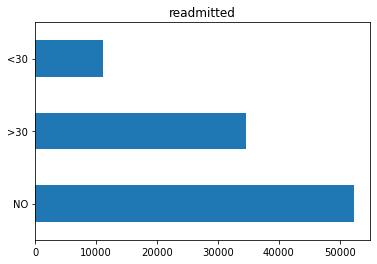

In [143]:
nominal_df = df[df.columns[df.dtypes == 'object']]
for col in nominal_df.columns:
    nominal_df[col].value_counts().plot(kind = "barh")
    plt.title(col)
    plt.show()

##### wielowymiarowa

In [144]:
df.describe()

,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,98053.000000,98053.000000,98053.000000,98053.000000,98053.000000,98053.000000,98053.000000,98053.000000,98053.000000,98053.000000,98053.000000,98053.000000
mean,66.260339,2.025813,3.753368,5.776692,4.421976,43.148073,1.350749,16.119650,0.376378,0.202462,0.646864,7.512060
std,15.590751,1.450117,5.309392,4.071640,2.993074,19.712033,1.708506,8.108476,1.283359,0.942892,1.271020,1.832497
min,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000
25%,55.000000,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,11.000000,0.000000,0.000000,0.000000,6.000000
50%,65.000000,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,75.000000,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,95.000000,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


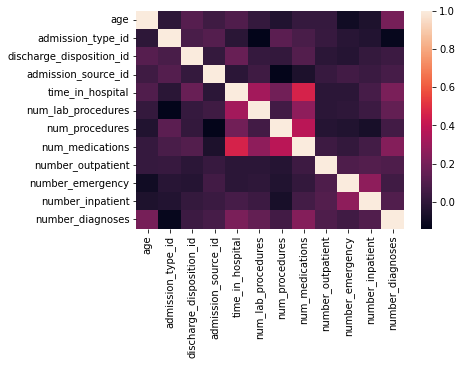

In [145]:
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns,
        yticklabels=corr.columns)

### Encoding zmiennych kategorycznych - Ordinal Encoding

In [146]:
enc1 = OrdinalEncoder()
enc1.fit(nominal_df)
transformed = enc1.transform(nominal_df)
cat_df = pd.DataFrame(transformed, columns = nominal_df.columns.values)
new_df = pd.concat([numerical_df.reset_index(drop = True), cat_df], axis = 1)
new_df

,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,15,1,1,7,3,59,0,18,0,0,...,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,25,1,1,7,2,11,5,13,2,0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0
2,35,1,1,7,2,44,1,16,0,0,...,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
3,45,1,1,7,1,51,0,8,0,0,...,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
4,55,2,1,2,3,31,6,16,0,0,...,0.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98048,75,1,3,7,3,51,0,16,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
98049,85,1,4,5,5,33,3,18,0,0,...,0.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0
98050,75,1,1,7,1,53,0,9,1,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
98051,85,2,3,7,10,45,2,21,0,0,...,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0


In [147]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98053 entries, 0 to 98052
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       98053 non-null  int64  
 1   admission_type_id         98053 non-null  int64  
 2   discharge_disposition_id  98053 non-null  int64  
 3   admission_source_id       98053 non-null  int64  
 4   time_in_hospital          98053 non-null  int64  
 5   num_lab_procedures        98053 non-null  int64  
 6   num_procedures            98053 non-null  int64  
 7   num_medications           98053 non-null  int64  
 8   number_outpatient         98053 non-null  int64  
 9   number_emergency          98053 non-null  int64  
 10  number_inpatient          98053 non-null  int64  
 11  number_diagnoses          98053 non-null  int64  
 12  race                      98053 non-null  float64
 13  gender                    98053 non-null  float64
 14  diag_1

Za pomocą funkcji OrdinalEncoder z pakietu skl.preprocessing zamieniliśmy zmienne kategoryczne na numeryczne.